# Code for competition

In [1]:
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load the dataset

In [2]:
samples = []
targets = []

images_ind = [186, 532, 515, 511, 531, 222, 537, 508]
for i in range(0, len(images_ind)):
    for j in range(0, images_ind[i]):
        temp = Image.open(f'training_data_final/Species{i + 1}/{j:05}.jpg').convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(images_ind))
        samples.append(image)
        targets.append(label)

X = np.array(samples)
y = np.array(targets, dtype=np.uint8)
print(X.shape, y.shape)
print(X.dtype, y.dtype, sep=", ")

(3542, 96, 96, 3) (3542, 8)
uint8, uint8


### Models metadata

In [3]:
input_shape = X.shape[1:]
image_shape = input_shape[:-1]
batch_size = 128
epochs = 200
labels = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Static augmentation

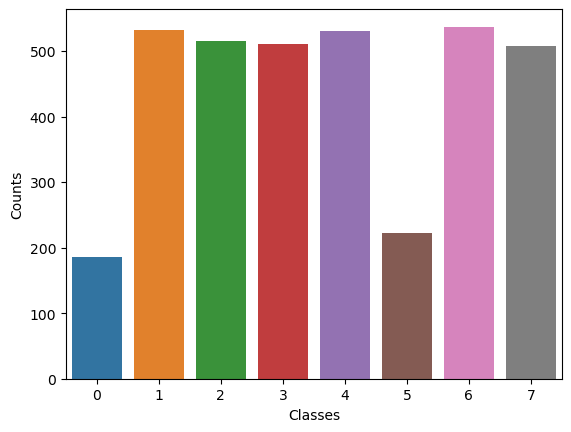

In [4]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

In [5]:
shift_range = 20
gen = ImageDataGenerator(rotation_range=90,  #TODO: choose the transformations
                         height_shift_range=shift_range,
                         width_shift_range=shift_range,
                         horizontal_flip=True,
                         vertical_flip=True,
                         zoom_range = 0.3,
                         fill_mode='reflect')

desired_amount = 1000

ref_list = []
aug_samples = []
aug_targets = []

for i in range(0, len(labels)):
    ref_list.append([])
  
for i in range(0, len(y)):
    ref_list[np.argmax(y[i])].append(X[i])

for i in range(0, len(labels)):
    length = len(ref_list[i])
    to_produce = desired_amount - length
    target = tfk.utils.to_categorical(i, len(labels))
    print(f'Computing {to_produce} augmented images for target {i}')
    aug_targets_i = np.full((length, len(labels)), target)
    aug_gen_i = gen.flow(np.array(ref_list[i]), 
                         aug_targets_i,
                         batch_size=1,
                         seed=seed,
                         shuffle=True)
    for j in range(0, to_produce):
        aug_samples.append(np.squeeze(next(aug_gen_i)[0]))
        aug_targets.append(target)

Computing 814 augmented images for target 0
Computing 468 augmented images for target 1
Computing 485 augmented images for target 2
Computing 489 augmented images for target 3
Computing 469 augmented images for target 4
Computing 778 augmented images for target 5
Computing 463 augmented images for target 6
Computing 492 augmented images for target 7


### Test pre-processing

In [23]:
# Saturation adjustment
new_aug_samples = []
for img in aug_samples: 
    new_aug_samples.append(np.array(tf.image.adjust_contrast(tf.image.adjust_saturation(img, 3), 0.9)))

### Show some example of augmented images

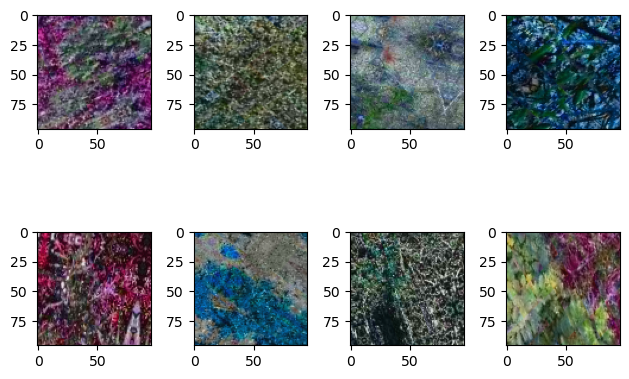

In [24]:
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col)
for i in range(num_row * num_col):

    img = random.choice(new_aug_samples)  # chaneg to new_aug_samples to see preprocessing effects
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.fromarray(img.astype(np.uint8)))

plt.tight_layout()
plt.show()

### Append new samples to the original one

In [25]:
X_aug = np.concatenate((X, np.array(aug_samples, dtype=np.uint8)))
y_aug = np.concatenate((y, np.array(aug_targets, dtype=np.uint8)))
print(X_aug.shape, y_aug.shape)
print(X_aug.dtype, y_aug.dtype, sep=", ")

(8000, 96, 96, 3) (8000, 8)
uint8, uint8


### Apply pre-processing
All that is done here must be included in the pre-processing phase

In [26]:
# Saturation adjustment
temp = []
for img in X_aug: 
    #temp.append(np.array(tf.image.adjust_saturation(img, 4)))
    temp.append(np.array(tf.image.adjust_contrast(tf.image.adjust_saturation(img, 3), 1.05)))

X_aug = np.array(temp)
print(X_aug.shape, X_aug.dtype, sep=", ")

(8000, 96, 96, 3), uint8


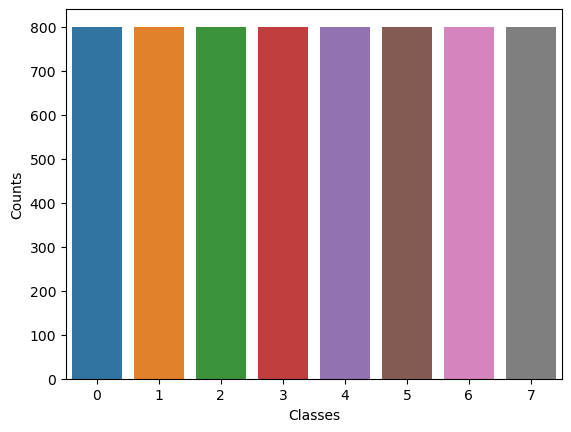

In [10]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y_aug], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

### Models definition functions

In [27]:
def build_tl_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.VGG16(include_top=False,
                                      weights="imagenet",
                                      input_shape=input_shape)

    # Use the supernet as feature extractor
    supernet.trainable = False
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier_1')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_1_dropout')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier_2')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_2_dropout')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'tl_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


def build_conv_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Conv2D(
        filters = 64,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(input_layer)
    
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_dropout')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'convolutional_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

### Split the dataset (85-15)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, stratify=y_aug, test_size=0.15)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6800, 96, 96, 3) (6800, 8)
(1200, 96, 96, 3) (1200, 8)


### Define the model

In [29]:
model = build_tl_model(input_shape)

# Apply fine tuning
model.get_layer('vgg16').trainable = True
for i, layer in enumerate(model.get_layer('vgg16').layers[:16]):
  layer.trainable=False

model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0         
 )                                                               
                                                                 
 classifier_1 (Dense)        (None, 256)               131328    
                                                                 
 classifier_1_dropout (Dropo  (None, 256)              0         
 ut)                                                             
                                                                 
 classifier_2 (Dense)        (None, 256)               657

### Train the model

In [30]:
# Transfer learning preprocessing (to be included in the preprocessing)
from tensorflow.keras.applications.vgg16 import preprocess_input
X_train_tl = np.array(preprocess_input(X_train), dtype=np.uint8)
X_val_tl = np.array(preprocess_input(X_val), dtype=np.uint8)

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
54/54 [==============================] - 64s 778ms/step - loss: 4.8576 - accuracy: 0.2826 - val_loss: 1.4857 - val_accuracy: 0.4575
Epoch 2/200
54/54 [==============================] - 31s 577ms/step - loss: 1.8578 - accuracy: 0.4019 - val_loss: 1.2979 - val_accuracy: 0.5292
Epoch 3/200
54/54 [==============================] - 32s 588ms/step - loss: 1.5032 - accuracy: 0.4722 - val_loss: 1.2218 - val_accuracy: 0.5725
Epoch 4/200
54/54 [==============================] - 32s 602ms/step - loss: 1.3714 - accuracy: 0.5129 - val_loss: 1.1707 - val_accuracy: 0.5983
Epoch 5/200
54/54 [==============================] - 33s 615ms/step - loss: 1.2233 - accuracy: 0.5551 - val_loss: 1.1328 - val_accuracy: 0.5967
Epoch 6/200
54/54 [==============================] - 34s 625ms/step - loss: 1.1598 - accuracy: 0.5812 - val_loss: 1.1043 - val_accuracy: 0.6108
Epoch 7/200
54/54 [==============================] - 34s 625ms/step - loss: 1.1004 - accuracy: 0.5982 - val_loss: 1.0622 - val_accuracy:

### Plot training results

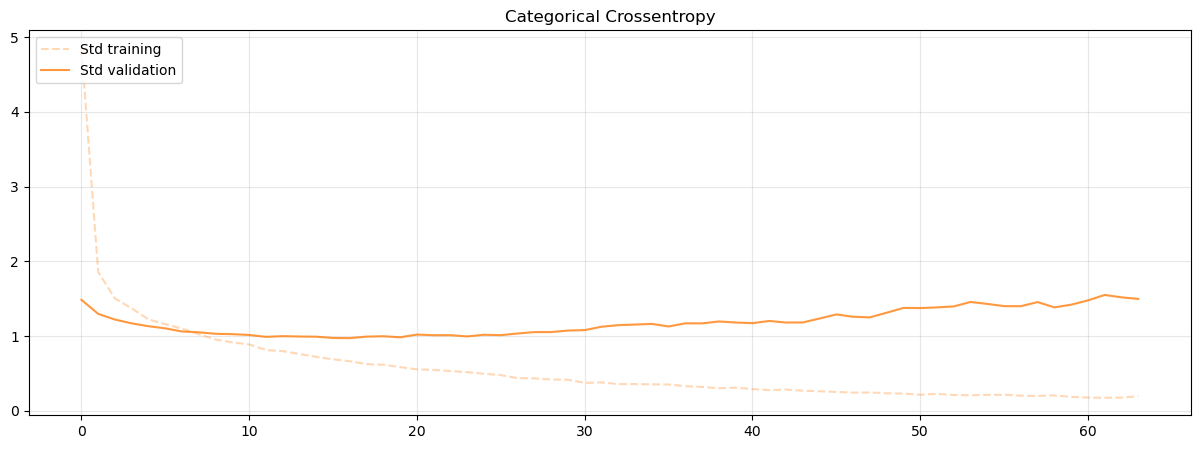

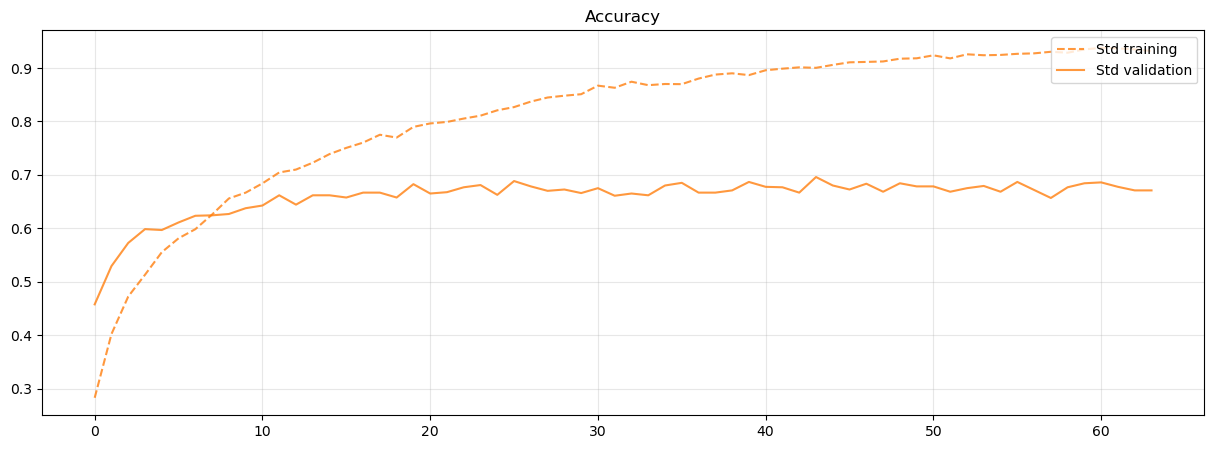

In [31]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

38/38 [==============================] - 12s 148ms/step
Accuracy: 0.6958
Precision: 0.6954
Recall: 0.6958
F1: 0.6945


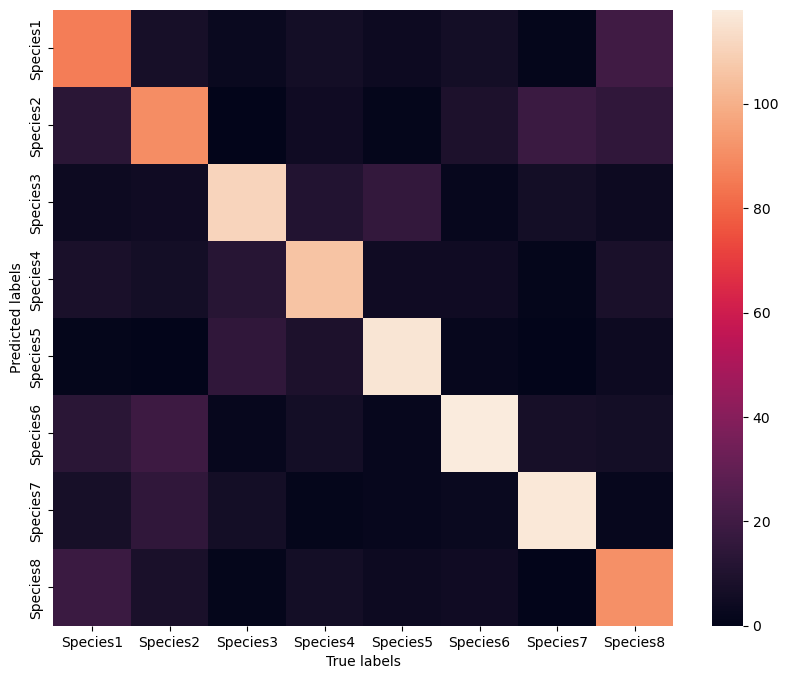

In [32]:
predictions = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the model

In [33]:
restored_model = tfk.models.load_model('best_model')
restored_loss, restored_acc = restored_model.evaluate(X_val, y_val, verbose=2)  #TODO: not right because validation set can change
loss, acc = model.evaluate(X_val, y_val, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    model.save('best_model')
else:
    print("No improvement!")

38/38 - 7s - loss: 0.9210 - accuracy: 0.6808 - 7s/epoch - 190ms/step
38/38 - 7s - loss: 1.1833 - accuracy: 0.6958 - 7s/epoch - 184ms/step
Model improved!


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets
